## Multi-label classification using Satellite images

These images are not at all like ImageNet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import * #ConvLearner, get_cv_idxs #*

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:
import os
os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('data/cache/planet/tmp', exist_ok=True)

#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
#!ln -s /cache/planet/tmp {PATH}

In [5]:
#ls {PATH}
import os
print(os.listdir(PATH))

['tmp', 'sample_submission_v2.csv', '.Sources', 'train-jpg', 'test-jpg-additional', 'train_v2.csv', 'test-jpg', 'models', '__MACOSX']


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

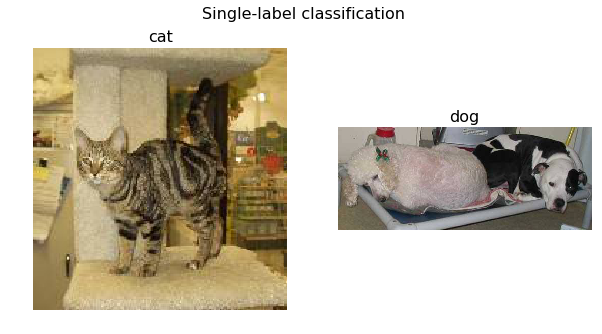

In [8]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

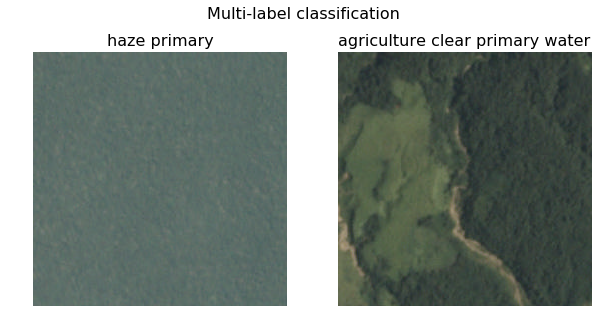

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)  #from fastai 

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
from fastai.transforms import * #tfms_from_model
from fastai.dataset import ImageClassifierData

In [13]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [14]:
data = get_data(256)

Fastai follows the Pytorch concepts of `dataset` (_ds) returns an image, whereas a `data loader` (_dl) returns a minibatch.
`iter` is the Python way to create an iterator, and `next` returns another batch (from a given iterator). 
Below it returns the minibatch images `x` and the minibatch labels `y`

In [15]:
x,y = next(iter(data.val_dl))

In [16]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [17]:
list(zip(data.classes, y[0]))  # Lets take a look at the labels of the 0 image, below the ones with value 1.0

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

Notice the multiplication by 1.4 to make it more clear to see....

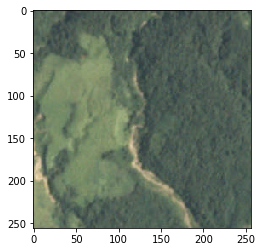

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

We resize to 64x64. We would not do this on a Imagenet like set of Images, because those would have been welll trained
Probably only the first 3 layers of models trained with Imagenet can be useful for these.

In [19]:
sz=64

In [20]:
data = get_data(sz)

We will not use bigger images, so to speed up we create the image

In [21]:
data = data.resize(int(sz*1.3), 'tmp')

A Jupyter Widget

In [22]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [23]:
#GSG 18/4/21 Not working with TypeError: 'module' object is not iterable
lrf=learn.lr_find()
learn.sched.plot()

In [24]:
lr = 0.2

In [25]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

TypeError: 'module' object is not iterable

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

### End